In [1]:
%reload_ext autoreload
%autoreload 2

import socket
import os
if socket.gethostname().startswith('ax'):
    path_prefix = '/mnt/smb/locker/miller-locker/users/Tahereh'
    path_codes = '/mnt/smb/locker/miller-locker/users/Tahereh/Codes/Perceptually_Aligned_Gradients/'
    os.chdir(path_codes)
    import sys
    sys.path.append(path_codes)
    sys.path.append('/mnt/smb/locker/miller-locker/users/Tahereh/Codes/Perceptually_Aligned_Gradients/Illusions')
elif socket.gethostname().startswith('demo'):
    path_prefix = '/home/tahereh/engram/users/Tahereh'
    path_codes = '/home/tahereh/engram/users/Tahereh/Codes/Public_Codes/Generative_Inference/'
    os.chdir(path_codes)
    import sys
    sys.path.append(path_codes)
    
print(os.getcwd())


## Settings of results 
fontsize_text = 25
color_text = 'mediumseagreen'
fontsize_text = 12


resultsdir = os.path.join(path_prefix, 'Research/Results/Generative_Inference')

# get the labels for imagenet
from Stimuli.load_stimuli import labels_imagenet


/home/tahereh/engram/users/Tahereh/Codes/Public_Codes/Generative_Inference
Kernel running on local computer 'demo'.
['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead shark']


/home/tahereh/anaconda3/envs/robustbenchpy311/lib/python3.11/site-packages/robustness/train.py:24: UserWarning: Could not import amp.
  warnings.warn('Could not import amp.')


image names:  ('self', 'image_name', 'image_original', 'cmap')


In [2]:
import torch

# for face net: 'advrobust_L2_eps_0.50' checkpoint 100
class Args:
    def __init__(self) -> None:
        self.model_arch = 'resnet50'
        
        self.dataset_model = 'imagenet' # 'imagenetvggface2'#'vggface2' #'imagenet'
        self.model_training ='advrobust_L2_eps_3.00' ##'advrobust_L2_eps_0.50' #'advrobust_Linf_eps_4.00' #'advrobust_L2_eps_3.00' #'advrobust_Linf_eps_4.00' #'advrobust_L2_eps_0.50'  'advrobust_L2_eps_3.00' #
        
        # self.dataset_model =  'vggface2' #'imagenet' # 'imagenetvggface2'#'vggface2' #'imagenet'
        # self.model_training ='advrobust_L2_eps_0.50' ##'advrob
        
        # self.dataset_model =  'imagenetvggface2'#'vggface2' #'imagenet'
        # self.model_training ='advrobust_L2_eps_3.00' ##'advrob
        
        self.epoch_chkpnt = 'full'#'madryfull' #176 #100 #106 #100#'full' # 160 for vggface IncConfMSE #'full' 
        self.eval_dataset_identifier = 'vggface2_test'
        self.batch_size = 32


args = Args()

if args.dataset_model == 'vggface2':
    assert args.model_training == 'advrobust_L2_eps_0.50'
    args. norm_mean = torch.tensor([0.5, 0.5, 0.5]).cuda()
    args.norm_std = torch.tensor([0.5, 0.5, 0.5]).cuda()
    args.n_classes = 500
elif 'imagenet' in  args.dataset_model or 'places365' in args.dataset_model:
    args.norm_mean = torch.tensor([0.485, 0.456, 0.406]).cuda()
    args.norm_std = torch.tensor([0.229, 0.224, 0.225]).cuda()
    args.n_classes = 1000
else:
    raise ValueError(f"Dataset model {args.dataset_model} not supported yet")
          

#'vggface2'  'advrobust_L2_eps_0.50' 'full' 'vggface2_test' 32
# Load the model -----------------------------
model_args = {'model_arch': args.model_arch, 
              'model_training': args.model_training,
              'input_size': 224,
              'dataset': args.dataset_model,
              'epoch_chkpnt': args.epoch_chkpnt,
              'norm_mean': args.norm_mean,
              'norm_std': args.norm_std,
              'n_classes': args.n_classes,
            #   'inference': args.inference
              }

from Models import load_models
model, _ = load_models.load_models(model_args)
model = torch.nn.DataParallel(model).cuda()
_=model.eval()


Kernel running on local computer 'demo'.
['/home/tahereh/anaconda3/envs/robustbenchpy311/lib/python311.zip', '/home/tahereh/anaconda3/envs/robustbenchpy311/lib/python3.11', '/home/tahereh/anaconda3/envs/robustbenchpy311/lib/python3.11/lib-dynload', '', '/home/tahereh/anaconda3/envs/robustbenchpy311/lib/python3.11/site-packages', '/home/tahereh/engram/users/Tahereh/Codes/Github/lucent', '/home/tahereh/anaconda3/envs/robustbenchpy311/lib/python3.11/site-packages/setuptools/_vendor', '/home/tahereh/engram/users/Tahereh/Codes/Public_Codes/Generative_Inference/', '/home/tahereh/engram/users/Tahereh/Codes/Perceptually_Aligned_Gradients']
args is a dictionary
get_dict_hash: dataset: imagenet, model_arch: resnet50
Loading model from imagenet
Loading model from /home/tahereh/engram/users/Tahereh/Codes/Perceptually_Aligned_Gradients/Training/TrainedModels/train_resnet50_imagenet_eps_3.00/c27e4781-e806-451d-af40-a2e30d88ca6d/checkpoint.pt.best
=> loading checkpoint '/home/tahereh/engram/users/Tah

In [42]:
## test the generative inference function
from Stimuli.load_stimuli import ImageLoader
from Inference.Generative_infernece import generative_inference

model_config = {'model': model, 'dataset_model': args.dataset_model, **model_args}
## pretty print the model_config
# Reverse Diffusion
inference_config = {'loss_infer': 'ReverseDiffusion',#'IncreaseConfidence',# #'IncreaseConfidence', #'ReverseDiffusion', 
                    'loss_function': 'MSE',#'MSE',# #'CE', #'MSE', 
                    'n_itr':1001, 
                    'eps': 3, #3, 
                    'step_size': 0.1, #3
                    'diffusion_noise_ratio': 0.005,#0.05, 
                    'initial_inference_noise_ratio': 0.2,# #0.1, 
                    #'iterations_to_show': [0, 1, 2, 4, 8, 16, 20, 24,  32, 36, 40, 44, 48, 52, 56, 60, 64, 80, 90, 100],
                    # 'iterations_to_show': [0, 1, 2, 4, 8, 16, 20, 24,  32, 36, 40, 44, 48, 52, 60, 80, 100, 150, 180, 200],
                    'iterations_to_show': [0, 1, 2, 10, 50, 100,  200,  300, 400, 500, 600, 700,800,900,1000],

                    # 'iterations_to_show': [0, 1, 2, 4, 8, 16, 20, 32, 64, 80, 100, 128, 160, 180, 200, 240, 280, 320, 420, 520, 620, 720, 820, 920,],
                    'top_layer': 'all', #'layer4', #'avgpool', #'all',
                    'inference_normalization': 'off',
                    'recognition_normalization': 'on',
                    'misc_info': {'keep_grads': True,}
                    }
# # Increase Confidence
# inference_config = {'loss_infer': 'IncreaseConfidence',#'IncreaseConfidence',# #'IncreaseConfidence', #'ReverseDiffusion', 
#                     'loss_function': 'CE',#'MSE',# #'CE', #'MSE', 
#                     'n_itr':501, 
#                     'eps': 5, #0.5, 
#                     'step_size': 0.5, #0.5
#                     'diffusion_noise_ratio': 0.003,#0.05, 
#                     'initial_inference_noise_ratio': 0.01,#0.05, #0.1, 
#                     # 'iterations_to_show': [0, 1, 2, 4, 8, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 80, 90, 100],
#                     'iterations_to_show': [0, 1, 2, 10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
#                     'top_layer': 'all', #'layer4', #'avgpool', #'all',
#                     'inference_normalization': 'off',
#                     'recognition_normalization': 'off',
#                     'misc_info': {'keep_grads': True,}
#                     }



image_name = 'KanizsaSq' #'KanizsaRealContours' #'KanizsaSq' #'KanizsaRealContours' #'KanizsaSq' 
image, cmap = ImageLoader(args.dataset_model).load_image(image_name)


selected_inferred_patterns, perceived_categories, confidence_list, misc_info_dict = generative_inference(model_config, image, inference_config)
iteration_numbers = inference_config['iterations_to_show']
if inference_config['misc_info']['keep_grads']:
    selected_grad_patterns = misc_info_dict['grad_info']
else:
    selected_grad_patterns = []

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): SequentialWithArgs(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), str

/home/tahereh/anaconda3/envs/robustbenchpy311/lib/python3.11/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


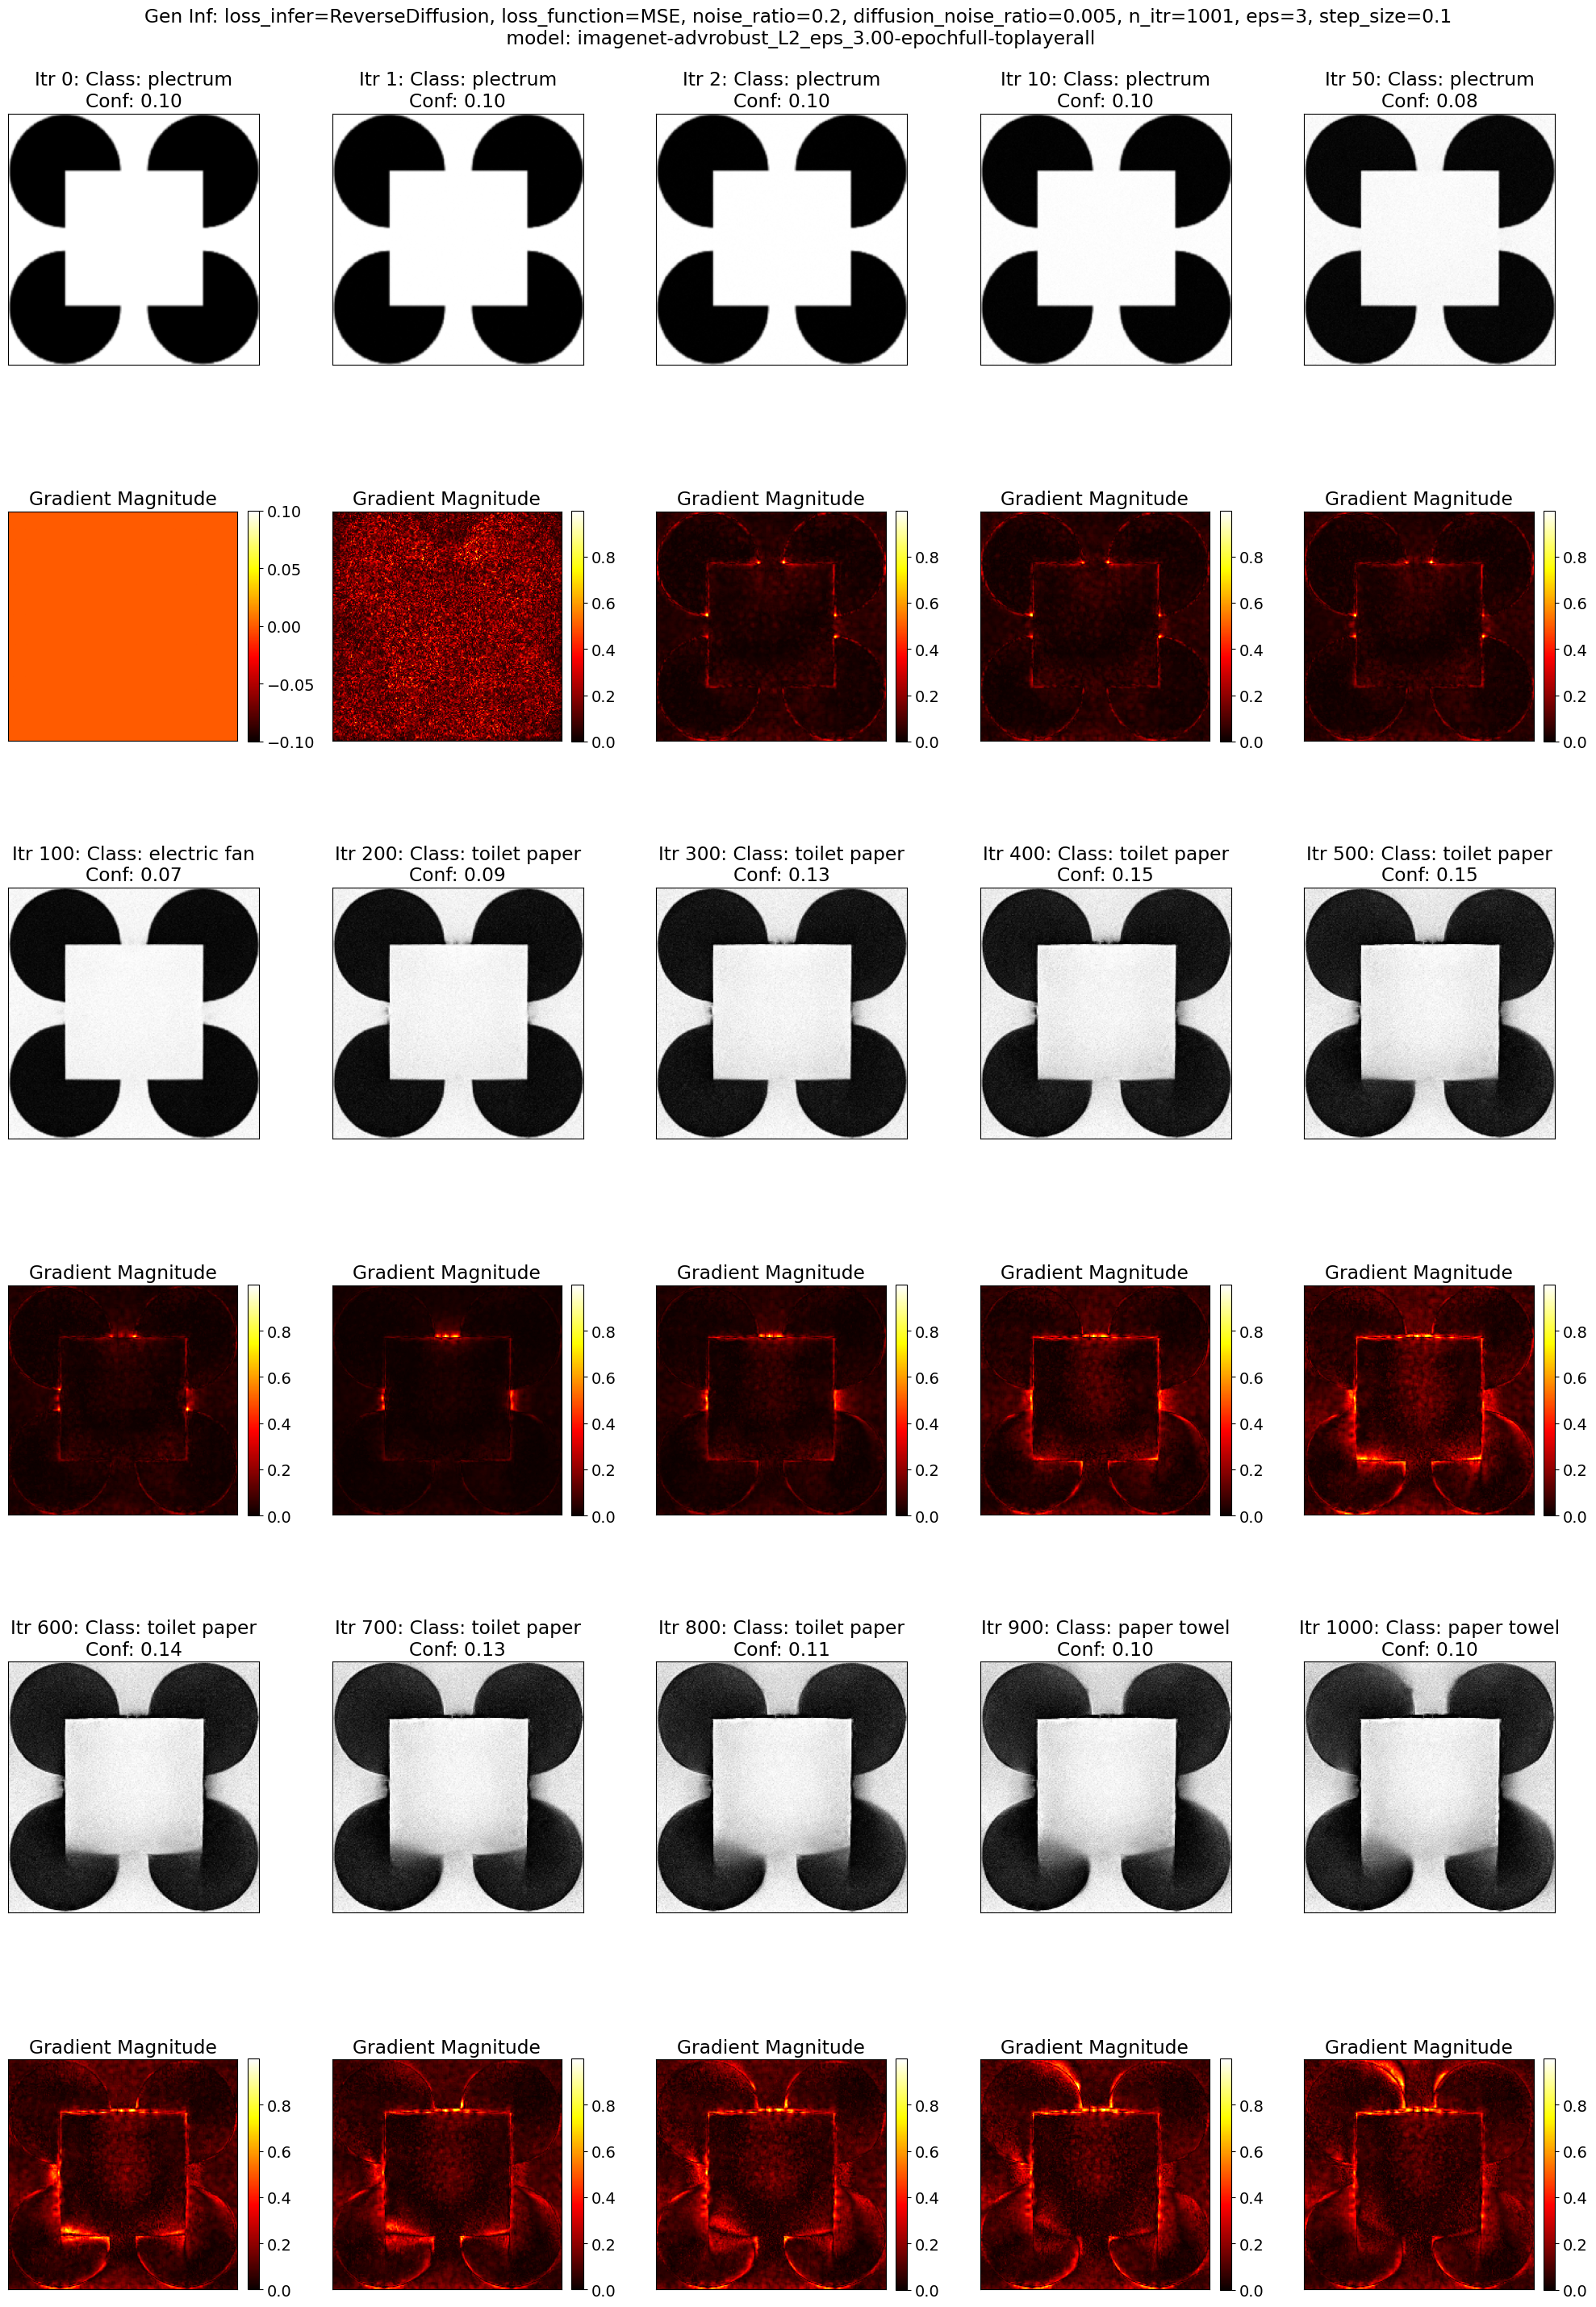

saved at: /home/tahereh/engram/users/Tahereh/Research/Results/Generative_Inference/imagenet-advrobust_L2_eps_3.00-full/KanizsaSq_all_geninf_imagenet_advrobust_L2_eps_3.00_epochfull_ReverseDiffusion_MSE_noise_ratio0.2_diffusion_noise_ratio0.005_n_itr1001_eps3_step_size0.1_confitr0_False_with_gradients.pdf


In [43]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch

# show the images and gradients in a grid - now with 2 rows per pattern
n_cols = 5
n_pattern_rows = len(selected_inferred_patterns)//n_cols + (1 if len(selected_inferred_patterns)%n_cols > 0 else 0)
if n_pattern_rows == 0:
    n_pattern_rows = 1
# Double the rows to accommodate gradients below each image
n_total_rows = n_pattern_rows * 2
fig, axes = plt.subplots(n_total_rows, n_cols, figsize=[20, 5*n_pattern_rows * 2])

if model_config['dataset_model'] == 'vggface2':
    norm_mean = torch.tensor([0.5,0.5,0.5]).view(-1, 1, 1).cuda()
    norm_std = torch.tensor([0.5,0.5,0.5]).view(-1, 1, 1).cuda()
elif model_config['dataset_model'] == 'imagenet' or model_config['dataset_model'] == 'imagenetvggface2':
    norm_mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).cuda()
    norm_std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).cuda()

for i in range(len(selected_inferred_patterns)):
    # Calculate positions for image and gradient
    row_idx = (i // n_cols) * 2  # Multiply by 2 to skip rows for gradients
    col_idx = i % n_cols
    
    # Get axes for both image and gradient
    if n_pattern_rows == 1:
        ax_img = axes[0] if n_cols == 1 else axes[col_idx]
        ax_grad = axes[1] if n_cols == 1 else axes[n_cols + col_idx]
    else:
        ax_img = axes[row_idx, col_idx]
        ax_grad = axes[row_idx + 1, col_idx]
        
    # Get the image and corresponding gradients
    image_to_compute = selected_inferred_patterns[i].squeeze(0).detach().cpu().numpy().transpose(1,2,0)
    gradients = selected_grad_patterns[i].squeeze(0).detach().cpu().numpy().transpose(1,2,0)
    
    # Normalize gradients for visualization
    grad_magnitude = np.sqrt(np.sum(gradients**2, axis=2))
    grad_normalized = (grad_magnitude - grad_magnitude.min()) / (grad_magnitude.max() - grad_magnitude.min() + 1e-8)
        
    
    predicted_emotion = 'N/A'
    confidence_emotion = 0
    first_itr_conf_got_high = 0
    emotion_detected = False
    color_title = 'black'
    
    # Plot image in top subplot
    if cmap=='gray':
        image_to_compute_in_gray = np.mean(image_to_compute, axis=2)
        ax_img.imshow(image_to_compute_in_gray, cmap='gray')
    else:
        ax_img.imshow(image_to_compute, cmap=cmap)
    # Plot gradient heatmap in bottom subplot
    gradient_plot = ax_grad.imshow(grad_normalized, cmap='hot')
    plt.colorbar(gradient_plot, ax=ax_grad, fraction=0.046, pad=0.04)
    
    # Set titles
    if model_config['dataset_model'] == 'imagenet':
        ax_img.set_title(f'Itr {iteration_numbers[i]}: Class: {labels_imagenet[perceived_categories[i]]}\nConf: {confidence_list[i]:.2f}', color=color_title)
    else:
        ax_img.set_title(f'Itr {iteration_numbers[i]}: Class: {perceived_categories[i]}\nConf: {confidence_list[i]:.2f}', color=color_title)
    
    ax_grad.set_title('Gradient Magnitude')
    
    # Remove ticks from both subplots
    ax_img.set_xticks([])
    ax_img.set_yticks([])
    ax_grad.set_xticks([])
    ax_grad.set_yticks([])

fig.suptitle(f'Gen Inf: loss_infer={inference_config["loss_infer"]}, loss_function={inference_config["loss_function"]}, noise_ratio={inference_config["initial_inference_noise_ratio"]}, diffusion_noise_ratio={inference_config["diffusion_noise_ratio"]}, n_itr={inference_config["n_itr"]}, eps={inference_config["eps"]}, step_size={inference_config["step_size"]}\n model: {args.dataset_model}-{args.model_training}-epoch{args.epoch_chkpnt}-toplayer{inference_config["top_layer"]}')

# Remove empty axes
for i in range(n_total_rows):
    for j in range(n_cols):
        pattern_idx = (i//2) * n_cols + j
        if pattern_idx >= len(selected_inferred_patterns):
            if n_pattern_rows > 1:
                fig.delaxes(axes[i, j])

plt.tight_layout()
plt.show()

# Save figure
figsave_dir = os.path.join(resultsdir, f'{args.dataset_model}-{args.model_training}-{args.epoch_chkpnt}/')
if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)

fig_name = f'{image_name}_{inference_config["top_layer"]}_geninf_{model_config["dataset_model"]}_{model_config["model_training"]}_epoch{model_config["epoch_chkpnt"]}_{inference_config["loss_infer"]}_{inference_config["loss_function"]}_noise_ratio{inference_config["initial_inference_noise_ratio"]}_diffusion_noise_ratio{inference_config["diffusion_noise_ratio"]}_n_itr{inference_config["n_itr"]}_eps{inference_config["eps"]}_step_size{inference_config["step_size"]}'
fig_name = fig_name + f'_confitr{first_itr_conf_got_high}_{emotion_detected}_with_gradients'

instance_counter = 0
while os.path.exists(os.path.join(figsave_dir, fig_name+'.pdf')):
    print('file already exists, adding instance number')
    if 'instance' in fig_name:
        fig_name = fig_name.split('_instance')[0]
    fig_name = fig_name + f'_instance{instance_counter}'
    instance_counter += 1

fig.savefig(os.path.join(figsave_dir, fig_name+'.pdf'), dpi=300, bbox_inches='tight')

print('saved at:', os.path.join(figsave_dir, fig_name+'.pdf'))

# Save results dictionary
dict_results = {
    'model_config': model_config,
    'inference_config': inference_config,
    'selected_inferred_patterns': selected_inferred_patterns,
    'selected_grad_patterns': selected_grad_patterns,
    'perceived_categories': perceived_categories,
    'iteration_numbers': iteration_numbers,

}
np.save(os.path.join(figsave_dir, fig_name+'.npy'), dict_results)

In [9]:
# save a copy of the resulted fig at: Selected_to_inspect
path_save_a_copy_significant = os.path.join(resultsdir,'Selected_to_inspect')

fig.savefig(os.path.join(path_save_a_copy_significant, fig_name+'.pdf'), dpi=300, bbox_inches='tight')

print(f"saved a copy of the resulted fig at: {path_save_a_copy_significant}")

saved a copy of the resulted fig at: /home/tahereh/engram/users/Tahereh/Research/Results/Generative_Inference/Selected_to_inspect


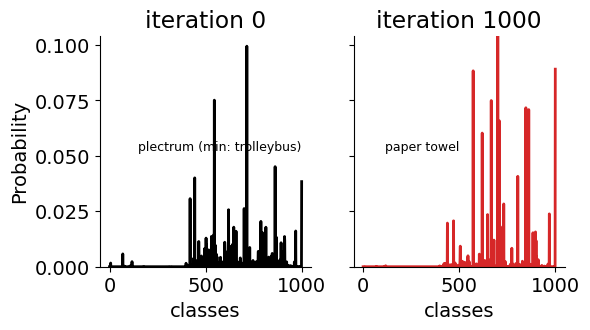

In [44]:
import matplotlib.pyplot as plt
save_fig_path = os.path.join(resultsdir, 'Selected_to_inspect','Class_probabilities')
fig.savefig(os.path.join(save_fig_path , fig_name+'.pdf'), dpi=300, bbox_inches='tight')

plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(1, 2, figsize=(6, 3))

y0 = misc_info_dict['probs_list'][0][0].detach().cpu().numpy()
y1 = misc_info_dict['probs_list'][-1][0].detach().cpu().numpy()
x0 = np.arange(y0.shape[0])
x1 = np.arange(y1.shape[0])

max_y = max(y0.max(), y1.max())
class_name_itr0 = labels_imagenet[perceived_categories[0]]
class_name_itr1 = labels_imagenet[perceived_categories[-1]]

class_min_itr0 = labels_imagenet[y0.argmin()]
class_min_itr1 = labels_imagenet[y1.argmin()]
last_itr = iteration_numbers[-1]

ax[0].plot(x0, y0, color='black', linewidth=2)
ax[1].plot(x1, y1, color='tab:red', linewidth=2)
ax[0].set_xlabel('classes')
ax[0].set_ylabel('Probability')
ax[0].set_title('iteration 0')
ax[0].text(x0.argmax(), max_y-0.05, class_name_itr0 + f' (min: {class_min_itr0})', ha='right', va='center', fontsize=9)

ax[1].set_xlabel('classes')
# ax[1].set_ylabel('Probability')
ax[1].set_title(f'iteration {last_itr}')
ax[1].text(x1.argmax()/2, max_y-0.05, class_name_itr1 , ha='right', va='center', fontsize=9)
ax[1].set_yticklabels([])
for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_ylim(0, max_y)

# plt.tight_layout()
# 
fig_tosave = fig_name + '_class_probabilities.pdf'

plt.savefig(os.path.join(save_fig_path, fig_tosave), bbox_inches='tight',dpi=300)
plt.show()

In [19]:
class_min_itr0, y0.argmin()

('trolleybus', 874)

saved a copy of the resulted fig at: /home/tahereh/engram/users/Tahereh/Research/Results/Generative_Inference/Selected_to_inspect


In [41]:
## Comparision between the two images
image_name1 = 'KanizsaSq'


image1, cmap1 = ImageLoader(args.dataset_model).load_image(image_name1)


selected_inferred_patterns1, perceived_categories1, confidence_list1, misc_info_dict1 = generative_inference(model_config, image1, inference_config)
image_name2 = 'KanizsaRealContours'
image2, cmap2 = ImageLoader(args.dataset_model).load_image(image_name2)
selected_inferred_patterns2, perceived_categories2, confidence_list2, misc_info_dict2 = generative_inference(model_config, image2, inference_config)
iteration_numbers = inference_config['iterations_to_show']




ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): SequentialWithArgs(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), str

/home/tahereh/anaconda3/envs/robustbenchpy311/lib/python3.11/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): SequentialWithArgs(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), str

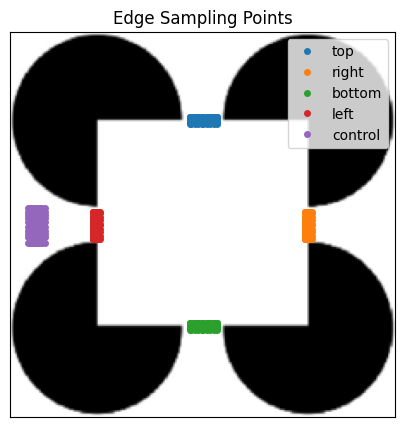

In [42]:
import PIL



left_x = 50
right_x = 173
top_y = 51
bottom_y = 171
coord_edge_start = 104
coord_edge_end = 120


# Function to generate sampling points for edges
def get_rect_points(x_start, x_end, y_start, y_end, n_points=10):
    """Generate a grid of points covering a rectangular region"""
    x_points = np.linspace(x_start, x_end, n_points)
    y_points = np.linspace(y_start, y_end, n_points)
    points = []
    for x in x_points:
        for y in y_points:
            points.append((int(y), int(x)))
    return points

# Function to generate edge points for selected edges
def generate_edge_points(edges_to_include):
    edge_points = {}
    for edge in edges_to_include:
        if edge == "top":
            edge_points['top'] = get_rect_points(coord_edge_start, coord_edge_end, top_y - 2, top_y + 2)
        elif edge == "right":
            edge_points['right'] = get_rect_points(right_x - 2, right_x + 2, coord_edge_start, coord_edge_end)
        elif edge == "bottom":
            edge_points['bottom'] = get_rect_points(coord_edge_start, coord_edge_end, bottom_y - 2, bottom_y + 2)
        elif edge == "left":
            edge_points['left'] = get_rect_points(left_x - 2, left_x + 2, coord_edge_start, coord_edge_end)
        elif edge == "control":
            control_x_start = max(0, left_x - 40)  # Ensure x-coordinates are non-negative
            control_x_end = max(0, left_x - 30)
            edge_points['control'] = get_rect_points(control_x_start, control_x_end, control_y_start - 2, control_y_end + 2)
    return edge_points

# Define sampling regions as rectangles
edge_points = {
    'top': get_rect_points(coord_edge_start, coord_edge_end, top_y - 2, top_y + 2),
    'right': get_rect_points(right_x - 2, right_x + 2, coord_edge_start, coord_edge_end),
    'bottom': get_rect_points(coord_edge_start, coord_edge_end, bottom_y - 2, bottom_y + 2),
    'left': get_rect_points(left_x - 2, left_x + 2, coord_edge_start, coord_edge_end)
}

# Add control region far to the left but ensure it's within valid bounds
control_x_start = max(0, left_x - 40)  # Ensure x-coordinates are non-negative
control_x_end = max(0, left_x - 30)
control_y_start = coord_edge_start
control_y_end = coord_edge_end
edge_points['control'] = get_rect_points(control_x_start, control_x_end, control_y_start - 2, control_y_end + 2)



# Visualize sampling points on the image
fig, ax_plot = plt.subplots(figsize=(5, 5))  # Squarish figure
image_name = 'KanizsaSq'
image, cmap = ImageLoader(args.dataset_model).load_image(image_name1)



image_resized = image.resize((224, 224))
plt.imshow(image_resized, cmap='gray')
for edge_name, points in edge_points.items():
    x_points = [x for y, x in points]
    y_points = [y for y, x in points]
    plt.plot(x_points, y_points, 'o', label=edge_name, markersize=4)
    ax_plot.set_xticks([])
    ax_plot.set_yticks([])
plt.legend()
plt.title("Edge Sampling Points")
fig_name = 'Edge_Sampling_Points_Kanizsa'


In [33]:
# save a copy of the resulted fig at: Selected_to_inspect
path_save_a_copy_significant = os.path.join(resultsdir,'Selected_to_inspect/Unit_activations_Data_comparison')

fig.savefig(os.path.join(path_save_a_copy_significant, fig_name+'.pdf'), dpi=300, bbox_inches='tight')

print(f"saved a copy of the resulted fig at: {path_save_a_copy_significant}")

saved a copy of the resulted fig at: /home/tahereh/engram/users/Tahereh/Research/Results/Generative_Inference/Selected_to_inspect/Unit_activations_Data_comparison


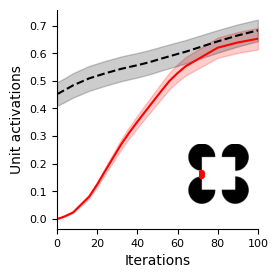

saved at: /home/tahereh/engram/users/Tahereh/Research/Results/Generative_Inference/imagenet-advrobust_L2_eps_3.00-madryfull/Receptive_field_['left']_edge_Edge_Sampling_Points_Kanizsa.pdf


In [43]:

edges_to_include = ['left']
img_width = model_config['input_size']
img_height = model_config['input_size']



# Create single figure for the plot
fig, ax_plot = plt.subplots(figsize=(3, 3))  # Squarish figure

# Define edge colors and line styles
colors = {'left': 'red', 'right': 'orange', 'top': 'blue', 'bottom': 'cyan', 'control': 'brown'}
line_styles = {'real': '--', 'illusory': '-'}  # Solid for real, dashed for illusory
line_colors = {'real': 'black', 'illusory': 'red'}

# Function to generate edge points for selected edges
def generate_edge_points(edges_to_include):
    edge_points = {}
    for edge in edges_to_include:
        if edge == "top":
            edge_points['top'] = get_rect_points(coord_edge_start, coord_edge_end, top_y - 2, top_y + 2)
        elif edge == "right":
            edge_points['right'] = get_rect_points(right_x - 2, right_x + 2, coord_edge_start, coord_edge_end)
        elif edge == "bottom":
            edge_points['bottom'] = get_rect_points(coord_edge_start, coord_edge_end, bottom_y - 2, bottom_y + 2)
        elif edge == "left":
            edge_points['left'] = get_rect_points(left_x - 2, left_x + 2, coord_edge_start, coord_edge_end)
        elif edge == "control":
            control_x_start = max(0, left_x - 40)  # Ensure x-coordinates are non-negative
            control_x_end = max(0, left_x - 30)
            edge_points['control'] = get_rect_points(control_x_start, control_x_end, control_y_start - 2, control_y_end + 2)
    return edge_points

# Generate edge points for selected edges
edge_points = generate_edge_points(edges_to_include)

# Helper function to calculate and plot responses with shaded areas
def plot_responses_with_shaded_error(ax, selected_patterns, label_prefix, line_style, line_color):
    for edge_name, points in edge_points.items():
        # Validate points to ensure they are within bounds of the image
        img_height, img_width = selected_patterns[0][0, 0].shape
        valid_points = [(y, x) for y, x in points if 0 <= x < img_width and 0 <= y < img_height]

        # Store all responses for each iteration
        all_responses = []
        for pattern in selected_patterns:
            pixel_responses = []
            for y, x in valid_points:
                # Invert the values so black (0) becomes 1 and white (1) becomes 0
                response = 1 - pattern[0, :, y, x].mean().item()
                pixel_responses.append(response)
            all_responses.append(pixel_responses)

        # Convert to numpy array for easier calculation
        all_responses = np.array(all_responses)  # shape: (n_iterations, n_pixels)

        # Calculate mean and SEM
        mean_responses = np.mean(all_responses, axis=1)
        sem_responses = np.std(all_responses, axis=1) / np.sqrt(all_responses.shape[1])

        # Plot mean response
        ax.plot(
            iteration_numbers,
            mean_responses,
            color=line_color,
            label=f"{label_prefix} {edge_name}",
            linestyle=line_style,
            linewidth=1.5,
        )

        # Fill between mean ± SEM
        ax.fill_between(
            iteration_numbers,
            mean_responses - sem_responses,
            mean_responses + sem_responses,
            color=line_color,
            alpha=0.2,  # Transparency for the shaded area
        )

# Plot responses for illusory contours with shaded error
plot_responses_with_shaded_error(ax_plot, selected_inferred_patterns1, "Illusory", line_styles['illusory'], line_colors['illusory'])

# Plot responses for real contours with shaded error
plot_responses_with_shaded_error(ax_plot, selected_inferred_patterns2, "Real", line_styles['real'], line_colors['real'])

# Configure the response plot
ax_plot.set_xlabel('Iterations', fontsize=10)
ax_plot.set_ylabel('Unit activations', fontsize=10)
ax_plot.tick_params(axis='both', which='major', labelsize=8)
ax_plot.spines['top'].set_visible(False)  # Remove top spine
ax_plot.spines['right'].set_visible(False)  # Remove right spine
# ax_plot.set_ylim([0, 0.8])
# ax_plot.set_yticks([0, 0.8])
# ax_plot.set_yticklabels([0, 0.8])
ax_plot.set_xlim([0, 100])


# Add Kanizsa image (illusory) as inset
ax_inset = ax_plot.inset_axes([0.65, 0.1, 0.3, 0.3])
last_pattern_illusory = selected_inferred_patterns1[0][0, 0].detach().cpu()
ax_inset.imshow(last_pattern_illusory, cmap='gray')

# Plot sampling points for selected edges on the Kanizsa figure
for edge_name in edge_points:  # Filter to include only selected edges
  # Filter to include only selected edges
    points = edge_points[edge_name]
    valid_points = [(y, x) for y, x in points if 0 <= x < img_width and 0 <= y < img_height]
    x_points = [x for y, x in valid_points]
    y_points = [y for y, x in valid_points]
    ax_inset.plot(x_points, y_points, 'o', color=colors[edge_name], fillstyle='none', markersize=2)

ax_inset.axis('off')

plt.tight_layout(pad=1.5)
plt.show()

# Save the figure
fig_name_receptivefield = f'Receptive_field_{edges_to_include}_edge_' + fig_name

fig.savefig(os.path.join(figsave_dir, fig_name_receptivefield + '.pdf'), dpi=300, bbox_inches='tight')
print('saved at:', os.path.join(figsave_dir, fig_name_receptivefield + '.pdf'))

In [31]:
# save a copy of the resulted fig at: Selected_to_inspect
path_save_a_copy_significant = os.path.join(resultsdir,'Selected_to_inspect/Unit_activations_Data_comparison')

fig.savefig(os.path.join(path_save_a_copy_significant, fig_name_receptivefield+'.pdf'), dpi=300, bbox_inches='tight')

print(f"saved a copy of the resulted fig at: {path_save_a_copy_significant}")


saved a copy of the resulted fig at: /home/tahereh/engram/users/Tahereh/Research/Results/Generative_Inference/Selected_to_inspect/Unit_activations_Data_comparison


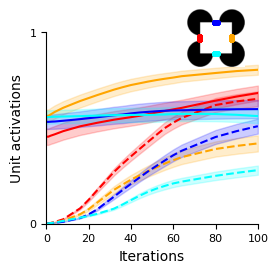

saved at: /home/tahereh/engram/users/Tahereh/Research/Results/Generative_Inference/imagenet-advrobust_L2_eps_3.00-madryfull/Receptive_field_['left', 'right', 'top', 'bottom']_edge_Edge_Sampling_Points_Kanizsa.pdf


In [44]:

edges_to_include = ['left', 'right', 'top', 'bottom']




# Create single figure for the plot
fig, ax_plot = plt.subplots(figsize=(3, 3))  # Squarish figure

# Define edge colors and line styles
colors = {'left': 'red', 'right': 'orange', 'top': 'blue', 'bottom': 'cyan', 'control': 'brown'}
line_styles = {'real': '-', 'illusory': '--'}  # Solid for real, dashed for illusory

# Function to generate edge points for selected edges
def generate_edge_points(edges_to_include):
    edge_points = {}
    for edge in edges_to_include:
        if edge == "top":
            edge_points['top'] = get_rect_points(coord_edge_start, coord_edge_end, top_y - 2, top_y + 2)
        elif edge == "right":
            edge_points['right'] = get_rect_points(right_x - 2, right_x + 2, coord_edge_start, coord_edge_end)
        elif edge == "bottom":
            edge_points['bottom'] = get_rect_points(coord_edge_start, coord_edge_end, bottom_y - 2, bottom_y + 2)
        elif edge == "left":
            edge_points['left'] = get_rect_points(left_x - 2, left_x + 2, coord_edge_start, coord_edge_end)
        elif edge == "control":
            control_x_start = max(0, left_x - 40)  # Ensure x-coordinates are non-negative
            control_x_end = max(0, left_x - 30)
            edge_points['control'] = get_rect_points(control_x_start, control_x_end, control_y_start - 2, control_y_end + 2)
    return edge_points

# Generate edge points for selected edges
edge_points = generate_edge_points(edges_to_include)

# Helper function to calculate and plot responses with shaded areas
def plot_responses_with_shaded_error(ax, selected_patterns, label_prefix, line_style):
    for edge_name, points in edge_points.items():
        # Validate points to ensure they are within bounds of the image
        img_height, img_width = selected_patterns[0][0, 0].shape
        valid_points = [(y, x) for y, x in points if 0 <= x < img_width and 0 <= y < img_height]

        # Store all responses for each iteration
        all_responses = []
        for pattern in selected_patterns:
            pixel_responses = []
            for y, x in valid_points:
                # Invert the values so black (0) becomes 1 and white (1) becomes 0
                response = 1 - pattern[0, :, y, x].mean().item()
                pixel_responses.append(response)
            all_responses.append(pixel_responses)

        # Convert to numpy array for easier calculation
        all_responses = np.array(all_responses)  # shape: (n_iterations, n_pixels)

        # Calculate mean and SEM
        mean_responses = np.mean(all_responses, axis=1)
        sem_responses = np.std(all_responses, axis=1) / np.sqrt(all_responses.shape[1])

        # Plot mean response
        ax.plot(
            iteration_numbers,
            mean_responses,
            color=colors[edge_name],
            label=f"{label_prefix} {edge_name}",
            linestyle=line_style,
            linewidth=1.5,
        )

        # Fill between mean ± SEM
        ax.fill_between(
            iteration_numbers,
            mean_responses - sem_responses,
            mean_responses + sem_responses,
            color=colors[edge_name],
            alpha=0.2,  # Transparency for the shaded area
        )

# Plot responses for illusory contours with shaded error
plot_responses_with_shaded_error(ax_plot, selected_inferred_patterns1, "Illusory", line_styles['illusory'])

# Plot responses for real contours with shaded error
plot_responses_with_shaded_error(ax_plot, selected_inferred_patterns2, "Real", line_styles['real'])

# Configure the response plot
ax_plot.set_xlabel('Iterations', fontsize=10)
ax_plot.set_ylabel('Unit activations', fontsize=10)
ax_plot.tick_params(axis='both', which='major', labelsize=8)
ax_plot.spines['top'].set_visible(False)  # Remove top spine
ax_plot.spines['right'].set_visible(False)  # Remove right spine
ax_plot.set_ylim([0, 1])
ax_plot.set_yticks([0, 1])
ax_plot.set_yticklabels([0, 1])
ax_plot.set_xlim([0, 100])


# Add Kanizsa image (illusory) as inset
ax_inset = ax_plot.inset_axes([0.65, 0.82, 0.3, 0.3])
last_pattern_illusory = selected_inferred_patterns1[0][0, 0].detach().cpu()
ax_inset.imshow(last_pattern_illusory, cmap='gray')

# Plot sampling points for selected edges on the Kanizsa figure
for edge_name in edge_points:  # Filter to include only selected edges
  # Filter to include only selected edges
    points = edge_points[edge_name]
    valid_points = [(y, x) for y, x in points if 0 <= x < img_width and 0 <= y < img_height]
    x_points = [x for y, x in valid_points]
    y_points = [y for y, x in valid_points]
    ax_inset.plot(x_points, y_points, 'o', color=colors[edge_name], fillstyle='none', markersize=2)

ax_inset.axis('off')

plt.tight_layout(pad=1.5)
plt.show()

# Save the figure
fig_name_receptivefield = f'Receptive_field_{edges_to_include}_edge_' + fig_name

fig.savefig(os.path.join(figsave_dir, fig_name_receptivefield + '.pdf'), dpi=300, bbox_inches='tight')
print('saved at:', os.path.join(figsave_dir, fig_name_receptivefield + '.pdf'))